1. What is perceptron? 
   A perceptron is a neural network with a single layer of input linear neurons followed with an output based on the sign(x)  
   function. A perceptron is the building block of a neural network that resembles that of a biological neuron.
2. What are the different types of perceptrons? Briefly describe each of them.
    Single layer perceptron: can only learn linearly seperable patterns where all vectors are conventionally column vectors and 
    the product of W^t*Xi transforms input into scaler. Follwing this, bias is added, and binary output is reached by using step 
    functions, where outputs will give 1 when z > 0, and 0 if not.
    Multiple layer perceptron: refered to as feed-forward networks, where the flow of information starts in the first layer and 
    continues in a consistent direction until output layer is reached. There are two weight matrices (W, H) and corresponding bias 
    vectors (b, c) found in MLPs. In MLPs, there is at least one hidden layer activation function that is not linear.
3. What is a hard margin in a support vector machine model? Be specific.
    A hard margin refers to a boundary in SVM that allows zero errors, compared to a soft margin (allows some error). This 
    requires slightest distance from the decision boundary to the support vectors in the training dataset.
4. The effectiveness of a support vector machine model depends on:
    a: kernel
5. What is/are true about kernel in SVM?
    d: a, c

In [1]:
import boto3
import pandas as pd; pd.set_option('display.max_column', 100)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import recall_score
from sklearn.svm import SVC

## define bucket in which you are trying to reach
s3 = boto3.resource('s3')
bucket_name = 'daltondencklau-data445-bucket'
bucket = s3.Bucket(bucket_name)

## define csv file to read in the bucket
file_key= 'framingham.csv'

## syntax to allow us to read the file
bucket_object = bucket.Object(file_key)
file_object = bucket_object.get()
file_content_stream = file_object.get('Body')

## reading the data file
heart = pd.read_csv(file_content_stream)
heart.head()

/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [2]:
## dropping missing values
heart = heart.dropna()

In [3]:
## defining the input and target variables
X = heart[['age', 'currentSmoker', 'totChol', 'BMI', 'heartRate']]
Y = heart['TenYearCHD']

In [4]:
## creating a list to store the results
md1_results = list()
md2_results = list()
md3_results = list()
md4_results = list()

## creating a loop to run models 100 times

for i in range (0,100):
    
    print(i)
    
    ## splitting the data into 80% training and 20% testing
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)
    
    ## scaling the data
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.fit_transform(X_test)
    
    
    
    ## building the first model (NN)
    md1 = tf.keras.models.Sequential([
        
        ## defining how many neurons, input variables, and activation function to use
        tf.keras.layers.Dense(4, input_dim = 5, activation = 'tanh'),
        
        ## defining how many layers to use and what output activation function to use
        tf.keras.layers.Dense(2, activation = 'softmax')
    ])
    
    ## defining how model 1 will be estimated
    md1.compile(optimizer= 'sgd', loss = 'categorical_crossentropy', metrics = ['accuracy']) 
    md1.fit(X_train, tf.keras.utils.to_categorical(Y_train, num_classes = 2), epochs = 100, batch_size = 500, verbose = 0)
    
    ## predicting on the test dataset
    md1_preds = md1.predict(X_test)[:, 1]
    
    ## creating a 15% cutoff value
    md1_labels = np.where(md1_preds < 0.15,0, 1)
    
    ## computing the recall for model 1
    md1_recall = recall_score(Y_test, md1_labels)
    
    ## appending the results to a list
    md1_results.append(md1_recall)
    
    
    
    ## building the second model (NN)
    md2 = tf.keras.models.Sequential([
        
        ## defining how many neurons, input variables, and activation function to use
        tf.keras.layers.Dense(4, input_dim = 5, activation = 'relu'),
        
        ## defining how many layers to use and what output activation funciton to use
        tf.keras.layers.Dense(2, activation = 'softmax')
    ])
    
    ## defining how model 2 will be estimated
    md2.compile(optimizer = 'sgd',  loss = 'categorical_crossentropy', metrics = ['accuracy'])
    md2.fit(X_train, tf.keras.utils.to_categorical(Y_train, num_classes = 2), epochs = 100, batch_size= 500, verbose = 0)
    
    ## predicting on the testing dataset
    md2_preds = md2.predict(X_test)[:, 1]
    
    ## creating a 15% cuttoff value
    md2_labels = np.where(md2_preds < 0.15, 0, 1)
    
    ## computing the recall score for model 2
    md2_recall = recall_score(Y_test, md2_labels)
    
    ## appending the results to a list
    md2_results.append(md2_recall)
    
    
    
    ## building the third and fourth models (SVC)
    md3 = SVC(kernel= 'rbf', probability= True).fit(X_train, Y_train)
    md4 = SVC(kernel= 'poly', probability= True).fit(X_train, Y_train)
    
    ## predictiting on the testing data set for SVC models
    md3_preds = md3.predict_proba(X_test)[:,1]
    md4_preds = md4.predict_proba(X_test)[:,1]
    
    ## creating a 15% cuttoff value for SVC models
    md3_labels = np.where(md3_preds < 0.15, 0, 1)
    md4_labels = np.where(md4_preds < 0.15, 0, 1)
    
    ## calculating the recall score for the SVC models
    md3_recall = recall_score(Y_test, md3_labels)
    md4_recall = recall_score(Y_test, md4_labels)
    
    ## appending the results to a list for both SVC models
    md3_results.append(md3_recall)
    md4_results.append(md4_recall)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [5]:
## calculating the mean recall score from 100 iterations for all models
print('The average recall score for model 1 is', np.mean(md1_results))
print('The average recall score for model 2 is', np.mean(md2_results))
print('The average recall score for model 3 is', np.mean(md3_results))
print('The average recall score for model 4 is', np.mean(md4_results))

The average recall score for model 1 is 0.5485004076626631
The average recall score for model 2 is 0.6394421063563585
The average recall score for model 3 is 0.6518879323000604
The average recall score for model 4 is 0.5999568757774127


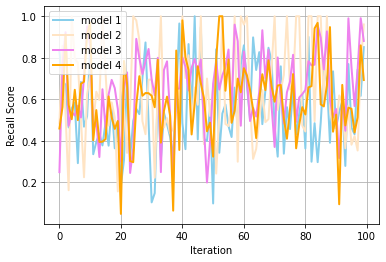

In [41]:
## creating a visualization showing the recall for each model at all iterations
plt.plot(md1_results , linewidth = 2, color = 'skyblue')
plt.plot(md2_results , linewidth = 2, color = 'bisque')
plt.plot(md3_results , linewidth = 2, color = 'violet')
plt.plot(md4_results , linewidth = 2, color = 'orange')
plt.xlabel('Iteration')
plt.ylabel('Recall Score')
plt.legend(loc = 'upper left', labels = ['model 1', 'model 2', 'model 3', 'model 4'])
plt.grid()
plt.grid
plt.show;

In [7]:
## based on the recall values and the above visualization, I would chose model 3 to predict TenYearCHD because it has the
## highest recall value